In [2]:
# Setup PySpark and Spark NLP on Colab
!wget https://setup.johnsnowlabs.com/colab.sh -O - | bash
!pip install wordcloud     # wordcloud-1.9.3
!pip install plotly     # plotly-5.15.0

--2024-03-24 16:16:26--  https://setup.johnsnowlabs.com/colab.sh
Resolving setup.johnsnowlabs.com (setup.johnsnowlabs.com)... 51.158.130.125
Connecting to setup.johnsnowlabs.com (setup.johnsnowlabs.com)|51.158.130.125|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp/master/scripts/colab_setup.sh [following]
--2024-03-24 16:16:27--  https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp/master/scripts/colab_setup.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1191 (1.2K) [text/plain]
Saving to: ‘STDOUT’

-                     0%[                    ]       0  --.-KB/s               Installing PySpark 3.2.3 and Spark NLP 5.3.2
setup Colab for PySpark 3.2.3 

In [ ]:
# Change the version of OpenJDK: for spark-nlp use only
# Colab crashes when restarting session
# !apt-get install openjdk-8-jdk-headless -qq > /dev/null
# import os
# os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
# !update-alternatives --set java /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java
# !java -version

In [ ]:
# Change the version of python (After change, restart session): for spark-nlp use only
# Colab crashes when restarting session
# !sudo apt-get install python3.8
# !sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.8 1

In [3]:
import sys
print(sys.version)

3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]


In [4]:
from pyspark import SparkConf, SparkContext, SQLContext
import re

import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud,STOPWORDS
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import KMeans
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler
import plotly.express as px

In [5]:
# Connect to google drive

from google.colab import drive
drive.mount('/content/drive')
import warnings
warnings.filterwarnings('ignore')

Mounted at /content/drive


In [6]:
# Configuration
conf = SparkConf()
sc = SparkContext(conf=conf)
sqlContext = SQLContext(sc)

In [7]:
import json

# Read the review file in Google Drive
review_path = "drive/MyDrive/yelp_academic_dataset_review.json"
review_rdd = sc.textFile(review_path)

# Parse json data within each record
review_rdd = review_rdd.map(lambda x: json.loads(x))
review_rdd = review_rdd.map(lambda x: (x['business_id'],x['stars'],x['useful'],x['funny'],x['cool'],x['text'],x['date']))

for row in review_rdd.take(10):
  print(row)

('XQfwVwDr-v0ZS3_CbbE5Xw', 3.0, 0, 0, 0, "If you decide to eat here, just be aware it is going to take about 2 hours from beginning to end. We have tried it multiple times, because I want to like it! I have been to it's other locations in NJ and never had a bad experience. \n\nThe food is good, but it takes a very long time to come out. The waitstaff is very young, but usually pleasant. We have just had too many experiences where we spent way too long waiting. We usually opt for another diner or restaurant on the weekends, in order to be done quicker.", '2018-07-07 22:09:11')
('7ATYjTIgM3jUlt4UM3IypQ', 5.0, 1, 0, 1, "I've taken a lot of spin classes over the years, and nothing compares to the classes at Body Cycle. From the nice, clean space and amazing bikes, to the welcoming and motivating instructors, every class is a top notch work out.\n\nFor anyone who struggles to fit workouts in, the online scheduling system makes it easy to plan ahead (and there's no need to line up way in adv

In [8]:
# Temp: take the first 20 rows for experiment
review_rdd = sc.parallelize(review_rdd.take(20))
for row in review_rdd.collect():
  print(row)

('XQfwVwDr-v0ZS3_CbbE5Xw', 3.0, 0, 0, 0, "If you decide to eat here, just be aware it is going to take about 2 hours from beginning to end. We have tried it multiple times, because I want to like it! I have been to it's other locations in NJ and never had a bad experience. \n\nThe food is good, but it takes a very long time to come out. The waitstaff is very young, but usually pleasant. We have just had too many experiences where we spent way too long waiting. We usually opt for another diner or restaurant on the weekends, in order to be done quicker.", '2018-07-07 22:09:11')
('7ATYjTIgM3jUlt4UM3IypQ', 5.0, 1, 0, 1, "I've taken a lot of spin classes over the years, and nothing compares to the classes at Body Cycle. From the nice, clean space and amazing bikes, to the welcoming and motivating instructors, every class is a top notch work out.\n\nFor anyone who struggles to fit workouts in, the online scheduling system makes it easy to plan ahead (and there's no need to line up way in adv

In [9]:
# Preprocess
nltk.download('stopwords')

# Remove special characters
pattern = r'[^a-zA-Z0-9\s]'     # Define a pattern that only includes whitespaces and alphanumeric characters
def remove_special_characters(text):
    text = re.sub(pattern, ' ', text)     # Replace characters not belonging to the pattern with whitespace
    return text.replace('\n', ' ')      # Replace '\n' with whitespace

# Remove indepedent numbers and stopwords
def is_number(s):
    if s.isdigit():
        return True
    try:
        float(s)
        return True
    except:
        return False
stop_words = set(stopwords.words('english'))
stop_words.add('')
def remove_numbers_and_stopwords(text):
    return " ".join([x for x in text.split(' ') if not is_number(x) and x not in stop_words])

# Remove abundant spaces
def remove_extra_spaces(text):
    return " ".join(text.split(' '))

# Lemmatization
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
def lemmatize(text):
    lemmatizer = WordNetLemmatizer()
    return " ".join([lemmatizer.lemmatize(word) for word in text.split(" ")])

def preprocess(text):
    text = remove_special_characters(text)
    text = text.lower()
    text = remove_numbers_and_stopwords(text)
    text = remove_extra_spaces(text)
    text = lemmatize(text)
    return text

# Remove rows with empty word lists
def filter_empty_and_none(row):
    return row[5] is not None and len(row[5]) > 0

review_preprocessed_rdd = (
    review_rdd
    .map(lambda x : (x[0], x[1], x[2], x[3], x[4], x[6], preprocess(x[5])))
    .filter(filter_empty_and_none)
)

for row in review_preprocessed_rdd.take(10):
  print(row)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


('XQfwVwDr-v0ZS3_CbbE5Xw', 3.0, 0, 0, 0, '2018-07-07 22:09:11', 'decide eat aware going take hour beginning end tried multiple time want like location nj never bad experience food good take long time come waitstaff young usually pleasant many experience spent way long waiting usually opt another diner restaurant weekend order done quicker')
('7ATYjTIgM3jUlt4UM3IypQ', 5.0, 1, 0, 1, '2012-01-03 15:28:18', 'taken lot spin class year nothing compare class body cycle nice clean space amazing bike welcoming motivating instructor every class top notch work anyone struggle fit workout online scheduling system make easy plan ahead need line way advanced like many gym make way write review without giving russell owner body cycle shout russell passion fitness cycling evident desire client succeed always dropping class check provide encouragement open idea recommendation anyone russell always wear smile face even kicking butt class')
('YjUWPpI6HXG530lwP-fb2A', 3.0, 0, 0, 0, '2014-02-05 20:30:30', 

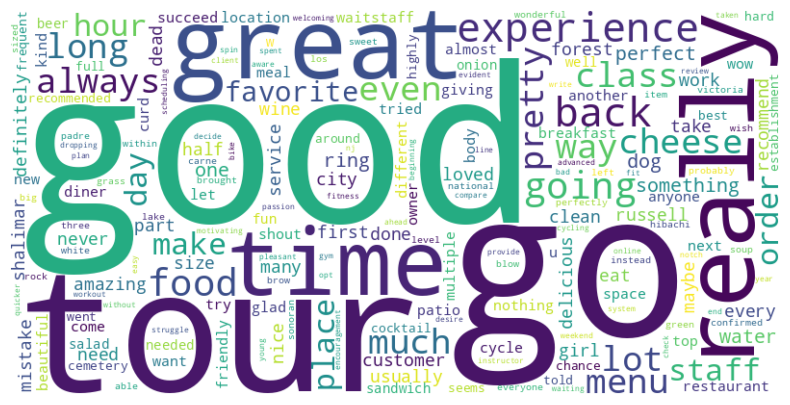

In [10]:
# WordCloud
# Flatten the word lists and concatenate them into a single string
words_rdd = review_preprocessed_rdd.map(lambda x: x[6])
str_rdd = words_rdd.reduce(lambda x, y: x + ' ' + y)

# Create a word cloud from the concatenated text
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(str_rdd)

# Display the generated word cloud image
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [11]:
# Tokenize
review_tokenized_rdd = (
    review_preprocessed_rdd.map(lambda x: (x[0], x[1], x[2], x[3], x[4], x[5], x[6].split(" ")))
)

# Convert to DataFrame
# business_id, stars, useful, funny, cool, date, text(list of words)
review_df = review_tokenized_rdd.toDF(['business_id', 'stars', 'useful', 'funny', 'cool', 'date', 'text'])
review_df.show(10)

+--------------------+-----+------+-----+----+-------------------+--------------------+
|         business_id|stars|useful|funny|cool|               date|                text|
+--------------------+-----+------+-----+----+-------------------+--------------------+
|XQfwVwDr-v0ZS3_Cb...|  3.0|     0|    0|   0|2018-07-07 22:09:11|[decide, eat, awa...|
|7ATYjTIgM3jUlt4UM...|  5.0|     1|    0|   1|2012-01-03 15:28:18|[taken, lot, spin...|
|YjUWPpI6HXG530lwP...|  3.0|     0|    0|   0|2014-02-05 20:30:30|[family, diner, b...|
|kxX2SOes4o-D3ZQBk...|  5.0|     1|    0|   1|2015-01-04 00:01:03|[wow, yummy, diff...|
|e4Vwtrqf-wpJfwesg...|  4.0|     1|    0|   1|2017-01-14 20:54:15|[cute, interior, ...|
|04UD14gamNjLY0IDY...|  1.0|     1|    2|   1|2015-09-23 23:10:31|[long, term, freq...|
|gmjsEdUsKpj9Xxu6p...|  5.0|     0|    2|   0|2015-01-03 23:21:18|[loved, tour, gra...|
|LHSTtnW3YHCeUkRDG...|  5.0|     2|    0|   0|2015-08-07 02:29:16|[amazingly, amazi...|
|B5XSoSG3SfvQGtKEG...|  3.0|    

In [12]:
# Word2Vec
from pyspark.ml.feature import Word2Vec

# Fit the Word2Vec model
word2vec = Word2Vec(vectorSize=200, seed=42, inputCol="text", outputCol="word2vec")
word2vec.setMaxIter(10)
word2vec_model = word2vec.fit(review_df)

# Transformation
word2vec_df = word2vec_model.transform(review_df).drop("text")

word2vec_df.select("word2vec").show(10, truncate=False)

# Save as json file
word2vec_path = "drive/MyDrive/review_word2vec"
word2vec_df.coalesce(1).write.format('json').save('drive/MyDrive/review_word2vec')

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
# Read the file(Rename the output json file to 'review_word2vec.json')
word2vec_rdd = sc.textFile("drive/MyDrive/review_word2vec/review_word2vec.json")

# Parse json data within each record
word2vec_rdd = (
    word2vec_rdd.map(lambda x: json.loads(x))
    .map(lambda x: (x['business_id'], x['stars'], x['useful'], x['funny'], x['date'], x['word2vec']['values']))
)

for row in word2vec_rdd.take(10):
  print(row)

In [18]:
# BOW(CountVectorizer)
from pyspark.ml.feature import CountVectorizer

# Fit the Word2Vec model
bow = CountVectorizer(inputCol="text", outputCol="bow")
bow_model = bow.fit(review_df)

# Transformation
bow_df = bow_model.transform(review_df).drop("text")

bow_df.select("bow").show(10, truncate=False)

# Save as json file
bow_path = "drive/MyDrive/review_bow"
bow_df.coalesce(1).write.format('json').save('drive/MyDrive/review_bow')

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|bow                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

In [26]:
# tf-idf
from pyspark.ml.feature import HashingTF, IDF, Tokenizer

# Apply HashingTF to get term frequency vectors
hashingTF = HashingTF(inputCol="text", outputCol="tf", numFeatures=150)
tf_df = hashingTF.transform(review_df)

# Apply IDF to the term frequency vectors
idf = IDF(inputCol="tf", outputCol="idf")
idf_model = idf.fit(tf_df)
idf_df = idf_model.transform(tf_df)

# Compute TF-IDF using the two columns
tf_idf_rdd = idf_df.rdd

def compute_tf_idf(tf, idf):
  return (tf.toArray() * idf.toArray()).tolist()

tfidf_rdd = tf_idf_rdd.map(
   lambda x: (x[0], x[1], x[2], x[3], x[4], x[5], compute_tf_idf(x[7], x[8]))
)

for row in tfidf_rdd.take(1):
  print(row[6])

# Save as json file
tfidf_rdd.coalesce(1).saveAsTextFile('drive/MyDrive/review_tfidf')

[0.0, 0.0, 0.0, 0.6466271649250525, 0.0, 5.011051873981472, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0986122886681098, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.252762968495368, 0.965080896043587, 0.0, 1.0986122886681098, 0.6466271649250525, 1.4350845252893227, 1.9459101490553132, 0.0, 0.0, 3.3891914415488147, 0.0, 0.0, 0.0, 0.0, 3.860323584174348, 12.915760727603903, 1.0986122886681098, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.9459101490553132, 1.0986122886681098, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.4350845252893227, 0.0, 0.0, 0.6466271649250525, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.6582280766035324, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.965080896043587, 0.0, 0.0, 0.0, 1.6582280766035324, 0.0, 0.0, 0.0, 0.0, 0.965080896043587, 0.0, 0.0, 0.0, 1.0986122886681098, 0.0, 0.0, 0.8472978603872037, 4.394449154672439, 0.0, 0.0, 3.860323584174348, 0.0, 5.011051873981472, 0.0, 0.0, 0.965080896043587, 0.0, 0.0, 0.0, 0.965080896043587, 0.0, 

In [ ]:
# BERT: Colab crashes when trying to change the version of python
from sparknlp.base import DocumentAssembler
from sparknlp.annotator import SentenceDetector, BertSentenceEmbeddings
from pyspark.ml import Pipeline
import pyspark.sql.functions as F

review_doc_df = review_preprocessed_rdd.toDF(['business_id', 'stars', 'useful', 'funny', 'cool', 'date', 'text'])

# Initialize DocumentAssembler
documentAssembler = DocumentAssembler() \
    .setInputCol("text") \
    .setOutputCol("document")

# Initialize BERT Embeddings annotator
bert_embedding = BertSentenceEmbeddings.pretrained('sent_small_bert_L8_512') \
    .setInputCols(["document"]) \
    .setOutputCol("bert")

# Apply the transformations
bert_pipeline = Pipeline(
    staget = [
       documentAssembler,
       bert_embedding
    ]
)
bert_model = bert_pipeline.fit(review_doc_df)
bert_df = bert_model.transform(review_doc_df)

review_doc_df.show(10)

In [ ]:
# Glove: Colab crashes when trying to change the version of python
glove_embedding = WordEmbeddingsModel.pretrained("glove_100d", "en") \
.setInputCols(["document"]) \
.setOutputCol("glove")

# Apply the transformations
glove_pipeline = Pipeline(
    staget = [
       documentAssembler,
       glove_embedding
    ]
)
glove_model = glove_pipeline.fit(review_doc_df)
glove_df = glove_model.transform(review_doc_df)

# from pyspark.sql.functions import udf
# from pyspark.sql.types import ArrayType, FloatType

# @udf(ArrayType(FloatType()))
# def compute_tf_idf(tf, idf):
  #  num_features = 150
   # indexes, val_tf = tf
    #_, val_idf = idf
    #tf_idf = [0] * num_features
    #for i in range(len(val_tf)):
     # idx = indexes[i]
      #tf_idf[idx] = val_tf[idx] * val_idf[idx]
    #print(indexes)
    #return tf_idf

# Add TF-IDF column to the DataFrame
#tfidf_df = idf_df.withColumn("tfidf", compute_tf_idf("tf", "idf"))

# Show the DataFrame with TF-IDF column
# idf_df.select('tf', 'idf').show(10, truncate=False)